In [1]:
%env CUDA_VISIBLE_DEVICES=5
%env OMP_NUM_THREADS=16

env: CUDA_VISIBLE_DEVICES=5
env: OMP_NUM_THREADS=16


In [2]:
import torch
torch.set_grad_enabled(False)

In [3]:
# MODEL = "meta-llama/Llama-2-7b-hf"
MODEL = "meta-llama/Meta-Llama-3.1-8B"
BASE_PPL = 5.606692790985107

In [4]:
from transformers import AutoModelForCausalLM

MODEL_PATH = '/mnt/LLM/hub/models--meta-llama--Meta-Llama-3.1-8B/snapshots/13f04ed6f85ef2aa2fd11b960a275c3e31a8069e/'
MODEL_SEQLEN = 8192

model_pt = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    trust_remote_code=True, torch_dtype="auto", device_map='cpu',
)

def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
import functools


@functools.cache
def get_numel(path):
    return get_module_by_path(model_pt, path).weight.numel()

total_params = sum(p.numel() for p in model_pt.model.layers.parameters())

In [7]:
import tqdm
import pandas as pd 
import wandb
import functools


@functools.cache
def get_df_from_wandb(path):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(path)
    
    data_df_lines = []
    for run in tqdm.tqdm(runs): 
        data_df_lines.append({
            'Name': run.name,
            'Commit': run.commit,
            **run.summary._json_dict,
            **{k: v for k,v in run.config.items() if not k.startswith('_')},
        })
    data_df = pd.DataFrame(data_df_lines)
    return data_df

In [124]:
# data_df = get_df_from_wandb('rock-and-roll/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL')
data_df = pd.read_csv('/tmp/galqiwi/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL.csv')

data_df['layer'] = data_df['layer_name']
data_df['mse'] = data_df['relative_mse']

data_df = data_df[data_df['base_model'] == MODEL]

data_df = data_df[['layer', 'mse', 'wikitext2']]
data_df = data_df.dropna().copy()

from sklearn.linear_model import LinearRegression

layers = sorted(set(data_df['layer']))

scale_by_layer = {}
intercept_by_layer = {}

for layer_idx, layer in enumerate(layers):
    to_fit = data_df[data_df['layer'] == layer]
    to_fit = to_fit[to_fit['mse'] > 0.01]
    to_fit = to_fit[to_fit['mse'] < 0.06]
    # to_fit = to_fit[to_fit['wikitext2'] < 5.630]

    x = to_fit['mse'].values.reshape(-1, 1)
    # x = np.concatenate([x, x ** 2, x ** 3, x ** 4], axis=1)
    
    slope = LinearRegression(fit_intercept=False).fit(x, to_fit['wikitext2'] - BASE_PPL).coef_[0]
    
    scale_by_layer[layer] = slope.item()
    intercept_by_layer[layer] = BASE_PPL

/var/tmp/ipykernel_580331/1773517755.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv('/tmp/galqiwi/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL.csv')


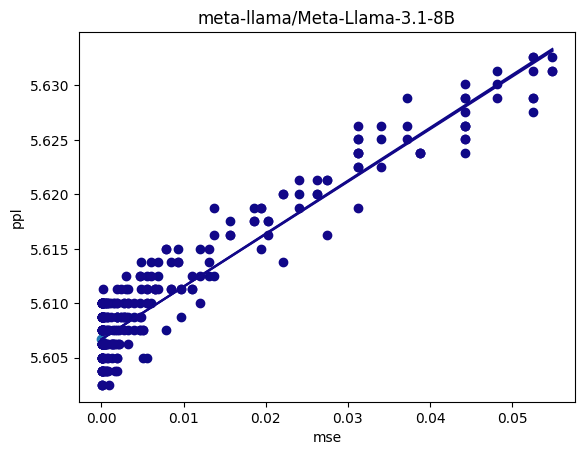

In [125]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


cmap = matplotlib.colormaps["plasma"]

plt.scatter([0.0], [5.606692790985107])

for layer_idx, layer in enumerate(sorted(layers, key=lambda layer: scale_by_layer[layer], reverse=True)[10:13]):
# for layer_idx, layer in enumerate(layers):
    to_plot = data_df[data_df['layer'] == layer]
    to_plot = to_plot[to_plot['mse'] < 0.06]
    # to_plot = to_plot[to_plot['wikitext2'] < 5.630]
    
    plt.scatter(to_plot['mse'], to_plot['wikitext2'], color=cmap(layer_idx / len(layers)))

    grid = np.linspace(0, to_plot['mse'].max(), 10)
    
    plt.plot(grid, intercept_by_layer[layer] + grid * scale_by_layer[layer], color=cmap(layer_idx / len(layers)))


plt.title(f'{MODEL}')
plt.xlabel('mse')
plt.ylabel('ppl')
plt.savefig(f'ppl_mse.png')

In [126]:
import requests
from ast import literal_eval
import pandas as pd

grids = literal_eval(requests.get(
    'https://gist.githubusercontent.com/BlackSamorez/c74f24a648eb8bbfbbbf83f3145ba3c7/raw/ddc3280a4861938e2e2034c29d6802817e26e799/gistfile1.txt'
).text)

grids = pd.DataFrame(grids)
grids['name'] = grids.apply(
    lambda row: 'edenn_d=' + str(row['edenn_d']) + ';edenn_n=' + str(row['edenn_n']),
    axis=1,
)
grids = grids[['bits', 'mse', 'name']]
print(len(grids))
grids.sample(3)

75


,bits,mse,name
19,1.333333,0.236341,edenn_d=3.0;edenn_n=16.0
23,1.666667,0.155457,edenn_d=3.0;edenn_n=32.0
73,0.555556,0.560862,edenn_d=9.0;edenn_n=32.0


In [127]:
import numpy as np
import math
import pandas as pd
import os
import json

eden_data_prefix = './eden_data/wandb'
eden_data_suffix = './files/wandb-summary.json'

eden_data = []
for run in os.listdir(eden_data_prefix):
    if not os.path.isfile(os.path.join(eden_data_prefix, run, eden_data_suffix)):
        continue
    with open(os.path.join(eden_data_prefix, run, eden_data_suffix)) as file:
        eden_data.append(json.load(file))

eden_data_df = pd.DataFrame(eden_data)
eden_data_df = eden_data_df[~eden_data_df['wikitext2_PPL'].isna()]
eden_data_df = eden_data_df[~eden_data_df['expected_mse'].isna()]
eden_data_df = eden_data_df[eden_data_df['expected_mse'] < 4 ** (-2)]
eden_data_df = eden_data_df[eden_data_df['expected_mse'] > 4 ** (-4)]
eden_data_df = eden_data_df[eden_data_df['expected_mse'] < 0.06]
eden_data_df = eden_data_df[['wikitext2_PPL', 'expected_mse']]
eden_data_df['effective_wbits'] = - np.log(eden_data_df['expected_mse']) / np.log(4)

In [135]:
noise_data_df = pd.read_csv('./noise_data/wandb_export_2024-08-15T05_04_22.552+03_00.csv')

noise_data_df = noise_data_df[['Name', 'State', 'wikitext2', 'noise_level']]
noise_data_df['noise_level'] = noise_data_df['noise_level'] ** 2
noise_data_df['effective_wbits'] = - np.log(noise_data_df['noise_level']) / np.log(4)
noise_data_df = noise_data_df[noise_data_df['State'] == 'finished']
print(set(noise_data_df['Name']))
noise_data_df = noise_data_df[noise_data_df['Name'] == 'Meta-Llama-3.1-8B']

{'Llama-2-7b-hf', 'Meta-Llama-3.1-8B'}


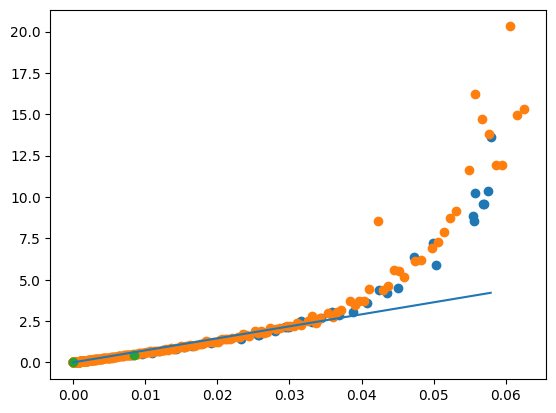

In [137]:
plt.scatter(eden_data_df['expected_mse'], eden_data_df['wikitext2_PPL'] - BASE_PPL)
grid = np.linspace(0, eden_data_df['expected_mse'].max(), 10)
plt.plot(grid, grid * sum(scale_by_layer.values()))
plt.scatter(noise_data_df['noise_level'], noise_data_df['wikitext2'] - BASE_PPL, label='fp16 + noise')
plt.scatter([6.147459e-05, 8.484117e-03], [0.0025033950805664062, 0.42316579818725586])

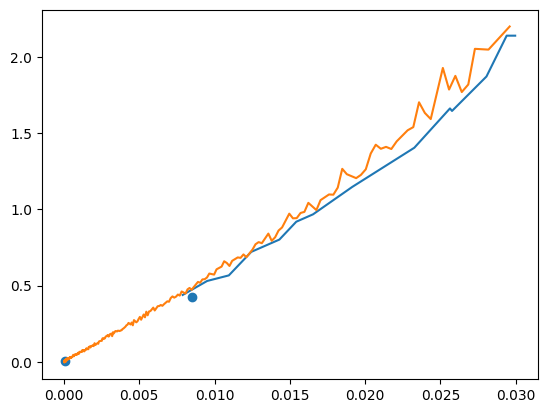

In [149]:
to_plot = eden_data_df
to_plot = to_plot[to_plot['expected_mse'] < 0.03]
to_plot = to_plot.copy().sort_values('expected_mse')

plt.plot(to_plot['expected_mse'], to_plot['wikitext2_PPL'] - BASE_PPL)
# grid = np.linspace(6.147459e-05, to_plot['expected_mse'].max(), 10)
# plt.plot(grid, grid * sum(scale_by_layer.values()))

to_plot_noise = noise_data_df
to_plot_noise = to_plot_noise[to_plot_noise['noise_level'] < 0.03]
to_plot_noise = to_plot_noise.copy().sort_values('noise_level')
plt.plot(to_plot_noise['noise_level'], to_plot_noise['wikitext2'] - BASE_PPL, label='fp16 + noise')
plt.scatter([6.147459e-05, 8.484117e-03], [0.0025033950805664062, 0.42316579818725586])

# plt.xscale('log')
# plt.yscale('log')

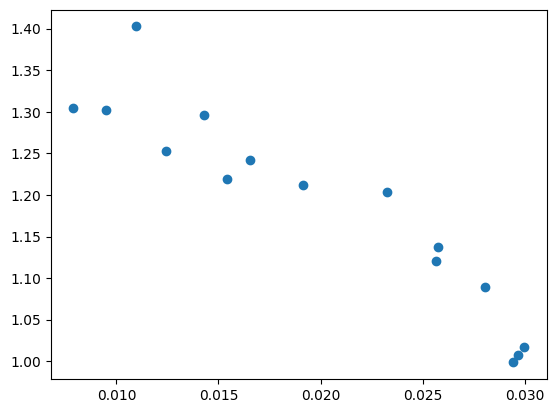

In [130]:
to_plot = eden_data_df
to_plot = to_plot[to_plot['expected_mse'] < 0.03]

plt.scatter(to_plot['expected_mse'], to_plot['expected_mse'] * sum(scale_by_layer.values()) / (to_plot['wikitext2_PPL'] - BASE_PPL))

In [12]:
grids[grids['name'] == 'edenn_d=2.0;edenn_n=256.0']

,bits,mse,name
12,4.0,0.007742,edenn_d=2.0;edenn_n=256.0


In [25]:
np.log(0.007742) / np.log(4)

-3.5065389885159317

In [21]:
sum(scale_by_layer.values()) * 0.007742

0.5439279832419264

In [23]:
6.038854598999023 - BASE_PPL

0.432161808013916

In [110]:
!git add *.ipynb *.png *.csv *.py && git commit -m upd && git push

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[galqiwi 6ea888f] upd
 1 file changed, 17 insertions(+), 13 deletions(-)
Counting objects: 6, done.
Delta compression using up to 255 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 715 bytes | 715.00 KiB/s, done.
Total 6 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To github.com:galqiwi/linear-layer-compression.git
   09a1217..6ea888f  galqiwi -> galqiwi
